# Stats

## Setup

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

### Imports

In [2]:
import os
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold

from amftrack.util.sys import storage_path
from amftrack.ml.width.models import first_model
from amftrack.ml.width.data_augmentation import data_augmentation

2022-06-07 15:58:21.692062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 15:58:21.692078: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ipausers/kahane/Wks/AMFtrack/amftrack/util/dbx.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-06-07 15:58:29.800314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/kahane/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-07 15:58:29.800336: W tensorflow/stream_executor/c

In [15]:
path = os.path.join(storage_path, "test_precise_1")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [16]:
im = imageio.imread(im_path)
print(im.shape)

(224, 120)


In [17]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(224,)


In [18]:
label = np. expand_dims(label, axis =1)

In [19]:
label.shape

(224, 1)

## Visualisation

### Big edge

In [20]:
i = 68

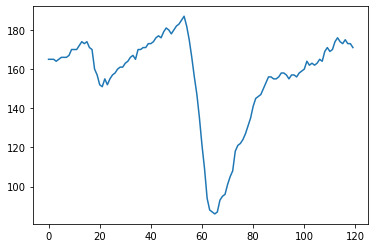

In [21]:
plt.plot(im[i,:])

In [22]:
label[i,:]

array([12.41270832])

### Medium edge

In [23]:
i = 12

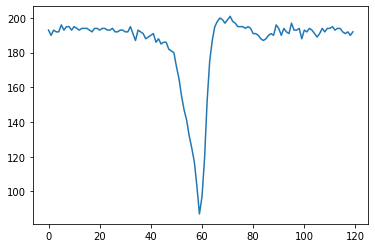

In [24]:
plt.plot(im[i,:])

In [25]:
label[i,:]

array([5.69865969])

### Small edge

In [26]:
i = 200

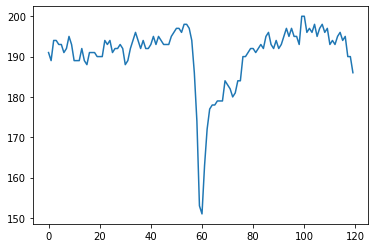

In [27]:
plt.plot(im[i,:])

In [28]:
label[i,:]

array([3.34934415])

## Data preparation

In [29]:
np.random.seed(11)

In [30]:
p = np.random.permutation(224)

In [31]:
training = p[:150]
test = p[150:]
print(len(training))
print(len(test))

150
74


In [32]:
train_feature = im[training, :]
train_label = label[training,0]
test_feature = im[test, :]
test_label = label[test, :]

In [33]:
test_feature.shape

(74, 120)

## Baseline

### One shot

In [34]:
mean = np.mean(train_label)
final_score = np.mean(np.abs(test_label-mean))

In [35]:
final_score

1.5074212494126962

### Cross validation

In [49]:
for train, valid in KFold(4).split(p):
    mean = np.mean(label[train,:])
    score = np.mean(np.abs(label[valid,:]-mean))
    print(score)

2.082754930457193
1.1375843651974278
1.0413637545111258
1.1992337417084913


In [95]:
np.mean([2.082754930457193,1.1375843651974278,1.0413637545111258,1.1992337417084913])

1.3652341979685596

## Small model

In [107]:
def model1():
    input = keras.Input(shape=(120, 1))
    scaling = keras.layers.Rescaling(1.0 / 128)(input)
    conv1 = keras.layers.Conv1D(
        filters=300, kernel_size=12, strides=3, activation="relu", name="conv1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(scaling)
    conv2 = keras.layers.Conv1D(
        filters=320,
        kernel_size=8,
        strides=3,
        activation="relu",
        name="conv2",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
    )(conv1)
    flatten = tf.keras.layers.Flatten()(conv2)
    dense1 = keras.layers.Dense(340, activation="relu", name="dense1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(flatten)
    dense2 = keras.layers.Dense(220, activation="relu", name="dense2", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(dense1)
    output = keras.layers.Dense(1, activation=None, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(dense2)
    model = keras.Model(inputs=input, outputs=output)
    return model

## Single cross validation

Step 1: we determine the model structure and hyper parameters using cross validation.
The cross validation is done on the training set. In each cross validation step, one step is retained for model evaluation and one set for early stopping evaluation.

## Step 1: Evaluate generalisation

In [108]:
def generalisation_estimator(n_split=4):
    evaluations = []
    history = []
    for train, valid in KFold(n_split).split(training):

        train, valid_e = next(KFold(4).split(train))
        train_feature = im[train, :]
        train_label = label[train,0]
        valid_e_feature = im[valid_e, :]
        valid_e_label = label[valid_e,0]
        valid_feature = im[valid, :]
        valid_label = label[valid, :]

        model = model1()
        model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
        metrics=[tf.keras.metrics.mean_absolute_error])

        history.append(model.fit(
        train_feature,
        train_label,
        batch_size=5,
        epochs=60,
        validation_data = (valid_e_feature, valid_e_label),
        ))
        evaluations.append(model.evaluate(valid_feature, valid_label))
        
    return model, history, evaluations

In [109]:
model, history, evaluations = generalisation_estimator()

Epoch 1/60
17/17 [==============================] - 1s 30ms/step - loss: 17.1238 - mean_absolute_error: 3.2148 - val_loss: 14.3234 - val_mean_absolute_error: 3.2598
Epoch 2/60
17/17 [==============================] - 0s 23ms/step - loss: 6.3989 - mean_absolute_error: 1.8706 - val_loss: 8.7455 - val_mean_absolute_error: 1.8558
Epoch 3/60
17/17 [==============================] - 0s 23ms/step - loss: 4.0710 - mean_absolute_error: 1.3192 - val_loss: 9.3824 - val_mean_absolute_error: 2.5939
Epoch 4/60
17/17 [==============================] - 0s 23ms/step - loss: 4.6508 - mean_absolute_error: 1.6119 - val_loss: 8.6480 - val_mean_absolute_error: 1.6144
Epoch 5/60
17/17 [==============================] - 0s 23ms/step - loss: 7.0369 - mean_absolute_error: 2.0248 - val_loss: 7.5021 - val_mean_absolute_error: 1.8832
Epoch 6/60
17/17 [==============================] - 0s 23ms/step - loss: 4.1425 - mean_absolute_error: 1.4042 - val_loss: 5.8500 - val_mean_absolute_error: 1.7413
Epoch 7/60
17/17 [==

Epoch 51/60
17/17 [==============================] - 0s 23ms/step - loss: 1.0856 - mean_absolute_error: 0.7518 - val_loss: 5.1233 - val_mean_absolute_error: 1.4783
Epoch 52/60
17/17 [==============================] - 0s 23ms/step - loss: 1.1197 - mean_absolute_error: 0.8066 - val_loss: 5.0851 - val_mean_absolute_error: 1.3119
Epoch 53/60
17/17 [==============================] - 0s 23ms/step - loss: 1.2089 - mean_absolute_error: 0.7972 - val_loss: 6.7413 - val_mean_absolute_error: 1.5297
Epoch 54/60
17/17 [==============================] - 0s 23ms/step - loss: 1.4184 - mean_absolute_error: 0.9370 - val_loss: 6.2432 - val_mean_absolute_error: 1.9085
Epoch 55/60
17/17 [==============================] - 0s 23ms/step - loss: 1.1768 - mean_absolute_error: 0.7910 - val_loss: 5.7321 - val_mean_absolute_error: 1.7284
Epoch 56/60
17/17 [==============================] - 0s 23ms/step - loss: 0.9565 - mean_absolute_error: 0.6961 - val_loss: 5.3689 - val_mean_absolute_error: 1.4958
Epoch 57/60
17/1

17/17 [==============================] - 0s 24ms/step - loss: 1.6820 - mean_absolute_error: 0.8745 - val_loss: 4.7452 - val_mean_absolute_error: 1.3097
Epoch 30/60
17/17 [==============================] - 0s 24ms/step - loss: 2.5017 - mean_absolute_error: 1.2052 - val_loss: 6.0111 - val_mean_absolute_error: 1.4704
Epoch 31/60
17/17 [==============================] - 0s 23ms/step - loss: 2.0644 - mean_absolute_error: 1.0622 - val_loss: 7.2723 - val_mean_absolute_error: 2.4042
Epoch 32/60
17/17 [==============================] - 0s 24ms/step - loss: 1.6950 - mean_absolute_error: 0.9677 - val_loss: 5.1561 - val_mean_absolute_error: 1.4655
Epoch 33/60
17/17 [==============================] - 0s 23ms/step - loss: 1.7365 - mean_absolute_error: 1.0092 - val_loss: 4.7674 - val_mean_absolute_error: 1.2952
Epoch 34/60
17/17 [==============================] - 0s 24ms/step - loss: 1.5431 - mean_absolute_error: 0.9328 - val_loss: 4.7539 - val_mean_absolute_error: 1.6838
Epoch 35/60
17/17 [=========

In [118]:
acc = [e[1] for e in evaluations]
mean = np.mean(acc)
std_dev = np.std(acc)
print(f"Mean: {mean} Std: {std_dev}")

Mean: 0.9381397813558578 Std: 0.22633092139606995


In [119]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [120]:
j = 1

(0, 20)

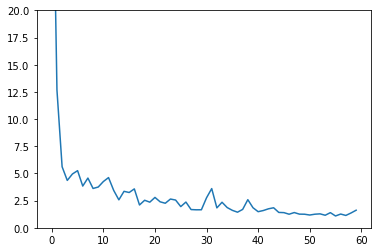

In [121]:
plt.plot(history[j].history['loss'])
plt.ylim(0,20)

(0, 20)

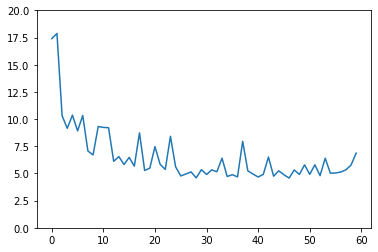

In [122]:
plt.plot(history[j].history['val_loss'])
plt.ylim(0,20)

(0, 20)

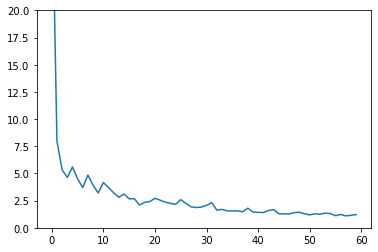

In [123]:
plt.plot(np.mean([history[i].history['loss'] for i in range(3)], axis = 0))
plt.ylim(0,20)

### Retrain best module

In [102]:
model = model1()

In [103]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])

In [104]:
history = model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=40
    )

Epoch 1/40
30/30 [==============================] - 1s 19ms/step - loss: 8.1788 - mean_absolute_error: 2.0019
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 3.0548 - mean_absolute_error: 1.2278
Epoch 3/40
30/30 [==============================] - 1s 19ms/step - loss: 3.0962 - mean_absolute_error: 1.2035
Epoch 4/40
30/30 [==============================] - 1s 19ms/step - loss: 2.7599 - mean_absolute_error: 1.1639
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 3.3859 - mean_absolute_error: 1.3846
Epoch 6/40
30/30 [==============================] - 1s 19ms/step - loss: 2.5518 - mean_absolute_error: 1.0875
Epoch 7/40
30/30 [==============================] - 1s 19ms/step - loss: 2.0603 - mean_absolute_error: 0.9472
Epoch 8/40
30/30 [==============================] - 1s 19ms/step - loss: 2.3586 - mean_absolute_error: 1.0925
Epoch 9/40
30/30 [==============================] - 1s 19ms/step - loss: 1.9698 - mean_absolute_error: 0.9647
Epoch 10/4

In [117]:
for i, key in enumerate(history.history.keys()):
    plt.subplot(2, 3, i+1)
    plt.plot(history.history[key])
    plt.title(key)
    plt.ylim(0, 3)
    plt.xlabel("Epochs")

AttributeError: 'list' object has no attribute 'history'

In [106]:
model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 6ms/step - loss: 2.6107 - mean_absolute_error: 1.1161


[2.610706329345703, 1.1160955429077148]

## Observe model behavior

In [144]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 8)
    plt.ylim(2, 8)

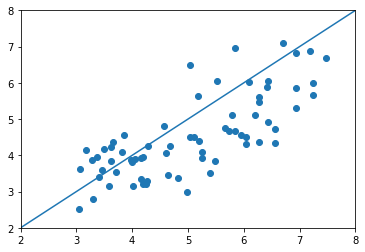

In [145]:
plot_against(model, test_feature, test_label)

In [148]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12], [np.mean(train_label), np.mean(train_label)])
    plt.plot([0,12],[0,12])

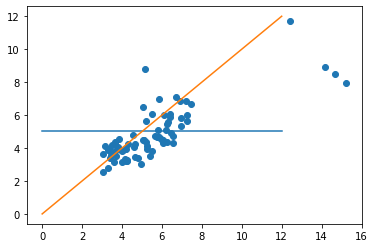

In [149]:
plot_against(model, test_feature, test_label)

## Save model

In [3]:
save_path = os.path.join(storage_path, "models", "model_test")
model.save(save_path)

NameError: name 'model' is not defined

### Fetching the model

In [4]:
model_ = keras.models.load_model(save_path)

In [5]:
model_.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 120, 1)]          0         
                                                                 
 rescaling_26 (Rescaling)    (None, 120, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 37, 300)           3900      
                                                                 
 conv2 (Conv1D)              (None, 10, 320)           768320    
                                                                 
 flatten_26 (Flatten)        (None, 3200)              0         
                                                                 
 dense1 (Dense)              (None, 340)               1088340   
                                                                 
 dense2 (Dense)              (None, 220)               750

# Brouillon

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = [
  {'hidden_layer_sizes': [ (50,), (100,), (20,20,20), (100, 100), (100, 100, 20), (10, 10), (30, 30, 20)], 
   'learning_rate_init':[0.001, 0.01],
   'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],
  }
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible accuracy)
clf = GridSearchCV(MLPRegressor(max_iter = 800,
                     early_stopping=True, 
                     n_iter_no_change = 10,
                     learning_rate_init = 0.0001,
                     alpha = 0.0001,
                     batch_size = 50,
                     hidden_layer_sizes=(40,40),
                     validation_fraction = 0.2,
                     random_state = 39,
                     verbose = 2), param_grid = param_grid, cv=3, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import KFold

n_split=3

for train_index, test_index in KFold(n_split).split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]

    model=create_model()
    model.fit(x_train, y_train,epochs=20)

    print('Model evaluation ',model.evaluate(x_test,y_test))

In [94]:
from sklearn.model_selection import KFold
KFold(3).split([1, 2, 3])

<generator object _BaseKFold.split at 0x7f6f829a92e0>